In [3]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import os
# from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm


In [4]:
transform_resize = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.ToTensor()])

cifar_dataset = CIFAR10("cifar10",
                         train=True,
                         download=True,
                         transform=transform_resize)
total_len = len(cifar_dataset)
train_len = int(total_len*0.9)
val_len = total_len - train_len

torch.manual_seed(2407)
train_ds, val_ds = random_split(cifar_dataset, [train_len, val_len])

batch_size = 128 
train_dl = torch.utils.data.DataLoader(train_ds,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds,
                                        batch_size=batch_size*2,
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10


In [5]:
# id_label_map = {}
# with open("./cifar100/cifar-100-python/meta", "rb") as f:
#   for i, id in enumerate(pickle.load(f)["fine_label_names"]):
#     id_label_map[i] = id 


In [6]:

# def show_image(img, id):
#   print(f"Label: {id_label_map[id]} ({id})")
#   plt.imshow(img.permute(1,2,0))

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

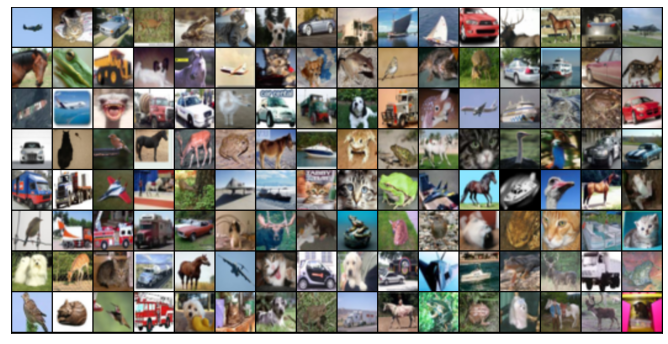

In [7]:
show_batch(train_dl)

In [8]:
class ImageClassifierBase(nn.Module):
  def training_step(self, batch):
    imgs, ids = batch
    out = self(imgs)
    loss = F.cross_entropy(out, ids)
    return loss
  
  def validation_step(self, batch):
    def acc(out, ids):
      _, preds = torch.max(out, dim=1)
      return torch.tensor(torch.sum(preds == ids).item() / len(preds))
    imgs, ids = batch
    out = self(imgs)
    loss = F.cross_entropy(out, ids)
    accuracy = acc(out, ids)
    return {"val_loss": loss, "val_acc": accuracy}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() 
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
  
  def print_epoch_stats(self, epoch, result):
    train_loss = result["train_loss"]
    val_loss = result["val_loss"]
    val_acc = result["val_acc"]
    print(f"Epoch {epoch}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f},\
          val_acc: {val_acc:.4f}")

In [9]:
# https://en.wikipedia.org/wiki/AlexNet
class AlexNetModified(ImageClassifierBase):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Flatten(),

        nn.Linear(192*3*3, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 10),
    )
  def forward(self, xb):
    return self.net(xb)

In [10]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_device()

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  out = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(out)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
  stats = []
  optim = opt_func(model.parameters(), lr)
  curr_val_acc, prev_val_acc = 0,0

  for epoch in range(epochs):
    model.train()
    epoch_losses = []

    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      epoch_losses.append(loss)
      optim.zero_grad()
      loss.backward()
      optim.step()

    result = evaluate(model, val_loader)
    result["train_loss"] = torch.stack(epoch_losses).mean().item()
    model.print_epoch_stats(epoch, result)
    stats.append(result)

    curr_val_acc = result["val_acc"]
    if(epoch > 20 and curr_val_acc > prev_val_acc):
      prev_val_acc = curr_val_acc
      torch.save(model.state_dict(), "./model64_cifar10.pth")

  return stats

In [12]:
device = get_device()
model = AlexNetModified()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)
print(device)

stats = fit(30, 1e-4, model, train_dl, val_dl)

cuda


100%|██████████| 352/352 [00:18<00:00, 18.81it/s]


Epoch 0, train_loss: 2.4918, val_loss: 2.2544,          val_acc: 0.1615


100%|██████████| 352/352 [00:12<00:00, 28.23it/s]


Epoch 1, train_loss: 1.9708, val_loss: 1.7155,          val_acc: 0.3151


100%|██████████| 352/352 [00:12<00:00, 28.49it/s]


Epoch 2, train_loss: 1.6598, val_loss: 1.5316,          val_acc: 0.4012


100%|██████████| 352/352 [00:12<00:00, 27.16it/s]


Epoch 3, train_loss: 1.4833, val_loss: 1.3742,          val_acc: 0.4711


100%|██████████| 352/352 [00:13<00:00, 25.80it/s]


Epoch 4, train_loss: 1.3258, val_loss: 1.3012,          val_acc: 0.5126


100%|██████████| 352/352 [00:12<00:00, 27.72it/s]


Epoch 5, train_loss: 1.2086, val_loss: 1.1748,          val_acc: 0.5669


100%|██████████| 352/352 [00:12<00:00, 27.73it/s]


Epoch 6, train_loss: 1.1163, val_loss: 1.1138,          val_acc: 0.5850


100%|██████████| 352/352 [00:12<00:00, 27.73it/s]


Epoch 7, train_loss: 1.0575, val_loss: 1.1234,          val_acc: 0.5908


100%|██████████| 352/352 [00:12<00:00, 27.81it/s]


Epoch 8, train_loss: 0.9950, val_loss: 1.0110,          val_acc: 0.6394


100%|██████████| 352/352 [00:12<00:00, 27.73it/s]


Epoch 9, train_loss: 0.9291, val_loss: 1.0076,          val_acc: 0.6370


100%|██████████| 352/352 [00:12<00:00, 28.07it/s]


Epoch 10, train_loss: 0.8772, val_loss: 1.0119,          val_acc: 0.6382


100%|██████████| 352/352 [00:12<00:00, 27.55it/s]


Epoch 11, train_loss: 0.8254, val_loss: 0.9882,          val_acc: 0.6533


100%|██████████| 352/352 [00:12<00:00, 28.16it/s]


Epoch 12, train_loss: 0.7629, val_loss: 0.9434,          val_acc: 0.6729


100%|██████████| 352/352 [00:12<00:00, 27.73it/s]


Epoch 13, train_loss: 0.7139, val_loss: 0.9729,          val_acc: 0.6704


100%|██████████| 352/352 [00:12<00:00, 27.33it/s]


Epoch 14, train_loss: 0.6595, val_loss: 0.9320,          val_acc: 0.6851


100%|██████████| 352/352 [00:12<00:00, 27.67it/s]


Epoch 15, train_loss: 0.6231, val_loss: 0.9855,          val_acc: 0.6808


100%|██████████| 352/352 [00:12<00:00, 27.42it/s]


Epoch 16, train_loss: 0.5689, val_loss: 1.0631,          val_acc: 0.6657


100%|██████████| 352/352 [00:12<00:00, 27.18it/s]


Epoch 17, train_loss: 0.5251, val_loss: 0.9776,          val_acc: 0.6897


100%|██████████| 352/352 [00:12<00:00, 27.35it/s]


Epoch 18, train_loss: 0.4681, val_loss: 1.0308,          val_acc: 0.6890


100%|██████████| 352/352 [00:12<00:00, 27.24it/s]


Epoch 19, train_loss: 0.4255, val_loss: 1.0845,          val_acc: 0.6846


100%|██████████| 352/352 [00:12<00:00, 27.28it/s]


Epoch 20, train_loss: 0.3890, val_loss: 1.1131,          val_acc: 0.6794


100%|██████████| 352/352 [00:12<00:00, 27.42it/s]


Epoch 21, train_loss: 0.3561, val_loss: 1.1128,          val_acc: 0.6953


100%|██████████| 352/352 [00:12<00:00, 27.36it/s]


Epoch 22, train_loss: 0.3128, val_loss: 1.3505,          val_acc: 0.6648


100%|██████████| 352/352 [00:12<00:00, 27.43it/s]


Epoch 23, train_loss: 0.2903, val_loss: 1.1902,          val_acc: 0.6872


100%|██████████| 352/352 [00:12<00:00, 27.50it/s]


Epoch 24, train_loss: 0.2584, val_loss: 1.2086,          val_acc: 0.6862


100%|██████████| 352/352 [00:12<00:00, 27.36it/s]


Epoch 25, train_loss: 0.2309, val_loss: 1.2610,          val_acc: 0.6986


100%|██████████| 352/352 [00:12<00:00, 27.51it/s]


Epoch 26, train_loss: 0.2040, val_loss: 1.3713,          val_acc: 0.6989


100%|██████████| 352/352 [00:12<00:00, 27.50it/s]


Epoch 27, train_loss: 0.1905, val_loss: 1.3085,          val_acc: 0.6807


100%|██████████| 352/352 [00:12<00:00, 27.54it/s]


Epoch 28, train_loss: 0.1607, val_loss: 1.4369,          val_acc: 0.6952


100%|██████████| 352/352 [00:12<00:00, 27.49it/s]


Epoch 29, train_loss: 0.1533, val_loss: 1.4773,          val_acc: 0.6935


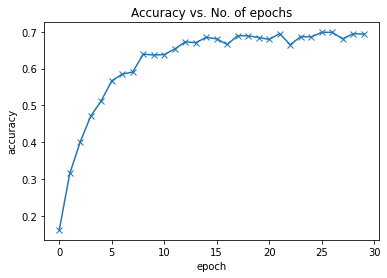

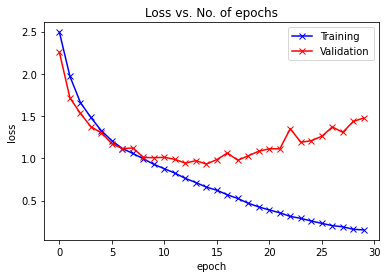

In [13]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
plt.figure(0)
plot_accuracies(stats)
plt.figure(1)
plot_losses(stats)

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)

    return cifar_dataset.classes[preds[0].item()]

img, label = cifar_dataset[10000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', cifar_dataset.classes[label], ', Predicted:', predict_image(img, model))
print(cifar_dataset.classes)
torch.save(model, "entire_model.pth")
